In [ ]:
import seaborn
import statsmodels
import pandas as pd
import numpy as np


### Regresión Lineal (y Red Neuronal Estándar)

- **Problema**: Predecir el IMC (Índice de Masa Corporal) de una persona.
- **Entradas**: Edad y Horas de Ejercicio semanales.
- **Modelo**:

IMC_predicho = (peso_1 * edad) + (peso_2 * horas_ejercicio) + sesgo

### Datos de ejemplo

- **Persona A**: 30 años, 5 horas de ejercicio.
- **Persona B**: 45 años, 2 horas de ejercicio.

### Procesamiento

Para predecir el IMC de la Persona A:

IMC_A = (w1 * 30) + (w2 * 5) + b

css
Copiar
Editar

Para predecir el IMC de la Persona B:

IMC_B = (w1 * 45) + (w2 * 2) + b




### Punto clave

El cálculo para la Persona B es **totalmente independiente** del cálculo para la Persona A. El modelo no tiene "memoria" de que acaba de ver a otra persona.

Cada muestra de datos es **un universo separado**.

---

## Esto es lo que hacen las redes neuronales estándar

Una red neuronal estándar (no recurrente):

- Procesa una muestra de datos (por ejemplo, una imagen o los datos de una persona).
- Luego **se olvida de ella** por completo al procesar la siguiente muestra.

---

## El Contraste: ¿Cuándo Necesitaríamos una RNN?

Ahora, modifiquemos tu ejemplo para que **sí necesitemos memoria**.

### Nuevo Problema

Predecir el **peso de una persona para mañana**, basándonos en su peso y horas de ejercicio de los últimos 7 días.

### Datos de entrada: Una secuencia de 7 días


### ¿Por qué una red estándar fallaría aquí?

Una red estándar:

- Trataría los 14 valores (7 pesos + 7 horas) como **características independientes**.
- Podría aprender que "el peso del día 3 es importante", pero **no entendería la secuencia**.
- No sabría que una **tendencia descendente** tiene un significado especial, diferente a un patrón irregular.

---

## ¿Cómo lo resuelve una RNN?

1. **Día 1**: Procesa los datos y genera un estado de memoria `h1`.
2. **Día 2**: Combina los datos del día con `h1` para generar `h2`.
3. **Día 3**: Usa `h2` para generar `h3`, y así sucesivamente.
4. ...
5. **Día 7**: Usa `h6` y los datos del día para generar `h7`.

### Predicción

La memoria final `h7` es un resumen completo de la semana.  
Con esa memoria, el modelo predice el peso del **Día 8**.

---

## Conclusión

- Las redes neuronales **estándar** procesan **muestras independientes**. No recuerdan nada de una muestra a otra.
- Las **RNNs (Redes Neuronales Recurrentes)** permiten que la información fluya entre pasos de tiempo.
- Así, una RNN **rompe la independencia** al usar **memoria** para capturar tendencias y dependencias temporales.

> ✅ Tu intuición es completamente correcta.


 Simularemos una serie de tiempo de temperatura de dos años (730 días) que tenga características realistas: una tendencia (ligero calentamiento), una estacionalidad (veranos cálidos, inviernos fríos) y un poco de ruido.

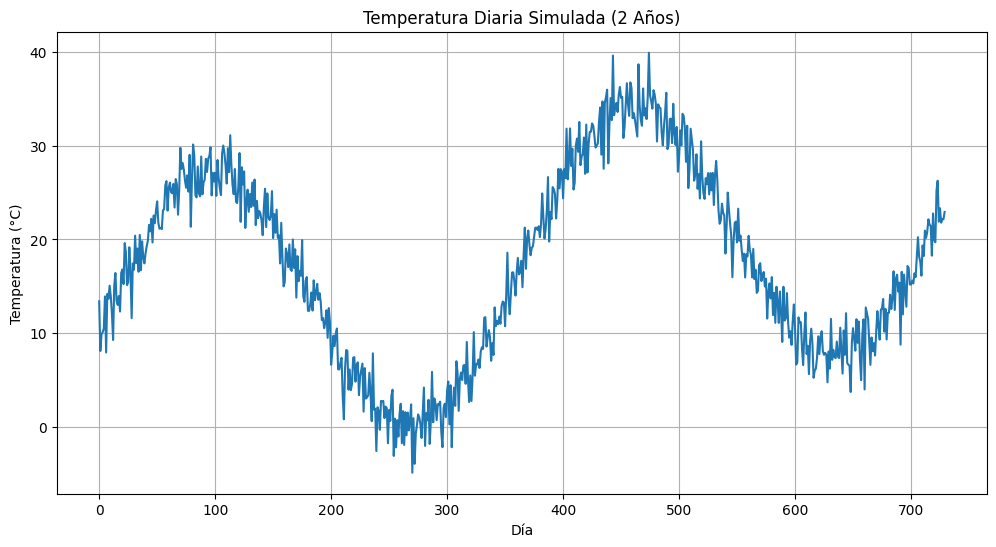

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- Generar Datos Simulados ---
# 730 días (2 años)
time = np.arange(730)

# Estacionalidad (temperaturas suben en verano, bajan en invierno)
# Amplitud de 15 grados, periodo de 365 días
seasonality = 15 * np.sin(2 * np.pi * time / 365)

# Tendencia (un ligero calentamiento global a lo largo del tiempo)
trend = 0.02 * time

# Ruido (variaciones diarias aleatorias)
noise = np.random.randn(730) * 2

# Serie de tiempo final
temperatures = 10 + seasonality + trend + noise # Base de 10 grados

# Visualizar nuestros datos realistas
plt.figure(figsize=(12, 6))
plt.title("Temperatura Diaria Simulada (2 Años)")
plt.xlabel("Día")
plt.ylabel("Temperatura (°C)")
plt.plot(time, temperatures)
plt.grid(True)
plt.show()

In [12]:
# --- 2. NORMALIZACIÓN DE DATOS (EL PASO CLAVE) ---
# Reshape para el scaler: de (730,) a (730, 1)
data_for_scaling = temperatures.reshape(-1, 1)

# Crear y ajustar el scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_for_scaling)

# Convertir a tensor de PyTorch
data = torch.FloatTensor(data_normalized)

Paso 2: La Ventana Deslizante (Crear Secuencias X e Y)
Ahora, a partir de nuestra única serie de 730 temperaturas, creamos las muestras de entrenamiento (Entrada, Salida). Usaremos los últimos 7 días (sequence_length = 7) para predecir el día siguiente.

In [13]:
# Convertimos a tensor de PyTorch
data = torch.FloatTensor(temperatures).view(-1, 1)

# Parámetros
sequence_length = 7
X = []
y = []

# Bucle para crear las secuencias
for i in range(len(data) - sequence_length):
    X.append(data[i : i + sequence_length])
    y.append(data[i + 1 : i + sequence_length + 1]) # La salida es el siguiente valor de la secuencia

X = torch.stack(X)
y = torch.stack(y)

print("Forma de X:", X.shape) # --> Debería ser [723, 7, 1]
print("Forma de y:", y.shape) # --> Debería ser [723, 7, 1]

Forma de X: torch.Size([723, 7, 1])
Forma de y: torch.Size([723, 7, 1])


Hemos creado 723 secuencias de entrenamiento. Cada una tiene una longitud de 7 días y 1 característica (la temperatura).

#Paso 3: División de Datos (Entrenamiento y Prueba)
Nunca debemos evaluar el modelo con los mismos datos con los que aprendió. Separamos los datos en un conjunto de entrenamiento (los primeros 600 días) y uno de prueba (el resto).

In [7]:
train_size = 600
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)

Forma de X_train: torch.Size([600, 7, 1])
Forma de X_test: torch.Size([123, 7, 1])


### Paso 4: La Matemática Detrás de Nuestro Modelo
Antes de ver las fórmulas, es crucial aclarar cómo nuestra única serie de 730 días se convierte en los cientos de muestras que la red usará para aprender. La clave es que **no "dividimos"** la serie en trozos aislados y no superpuestos. Si hiciéramos eso, desperdiciaríamos la mayor parte de la información sobre cómo un día influye en el siguiente.

En su lugar, usamos una técnica mucho más inteligente llamada **Ventana Deslizante (Sliding Window)**.

Imagina que tenemos una "lupa" o "ventana" que tiene un ancho de 7 días (nuestra `sequence_length=7`). Así es como la usamos para crear las muestras de entrenamiento (`X`, `Y`):

| # de Muestra | Secuencia de Entrada `X` (lo que ve la red) | Salida `Y` (lo que debe predecir) |
| :--- | :--- | :--- |
| **1** | `[Día 1, Día 2, ..., Día 7]` | `Día 8` |
| **2** | `[Día 2, Día 3, ..., Día 8]` <br> *¡La ventana se desliza un solo paso!* | `Día 9` |
| **3** | `[Día 3, Día 4, ..., Día 9]` | `Día 10` |
| **...** | ... | ... |
| **723** | `[Día 723, Día 724, ..., Día 729]` | `Día 730` |

Este método nos permite generar **723 muestras de entrenamiento superpuestas** a partir de una única serie, proporcionando muchísimos ejemplos ricos y contextuales para la red.

---

Ahora, con esta idea en mente, veamos cómo se aplican las fórmulas matemáticas a **cada una de estas secuencias**.

Aquí están las fórmulas exactas que nuestra RNN implementará. El modelo aprende a encontrar los valores óptimos para todos los pesos ($W$) y sesgos ($b$) para minimizar el error de predicción.

#### 1. La Célula Recurrente y el Estado Oculto (Memoria Vectorial)

El corazón de la RNN es el **estado oculto** ($h_t$), que actúa como la memoria de la red. Es crucial entender que $h_t$ no es un único número, sino un **vector**. El tamaño de este vector está determinado por el hiperparámetro `hidden_size`. En nuestro caso, al elegir `hidden_size=50`, cada estado oculto $h_t$ es un vector con 50 elementos.

Para cada paso de tiempo $t$ en una secuencia, la red calcula el nuevo vector de estado oculto $h_t$ combinando la entrada actual $x_t$ con el vector de estado oculto del paso anterior $h_{t-1}$.

$$
\underbrace{h_t}_{\text{Vector [50x1]}} = \tanh\left( \left( \underbrace{W_x}_{\text{Matriz [50x1]}} \cdot \underbrace{x_t}_{\text{Escalar [1x1]}} \right) + \left( \underbrace{W_h}_{\text{Matriz [50x50]}} \cdot \underbrace{h_{t-1}}_{\text{Vector [50x1]}} \right) + \underbrace{b_h}_{\text{Vector [50x1]}} \right)
$$

*   $\boldsymbol{h_t}$: El vector de estado oculto (memoria) en el paso actual $t$. Su dimensión es `hidden_size`.
*   $\boldsymbol{h_{t-1}}$: El vector de estado oculto del paso anterior. Para el primer paso, $h_0$ se inicializa a un vector de ceros.
*   $\boldsymbol{x_t}$: La entrada en el paso $t$ (la temperatura, un escalar en este caso).
*   $\boldsymbol{W_x, W_h}$: Matrices de pesos que la red aprende. Determinan cómo transformar la nueva entrada y la memoria pasada para crear la nueva memoria. Sus dimensiones dependen de `input_size` y `hidden_size`.
*   $\boldsymbol{b_h}$: Un vector de sesgos que la red aprende.
*   $\tanh$: La función de activación "Tangente Hiperbólica", aplicada elemento a elemento al vector resultante.

Este vector $h_t$ de 50 números es un resumen rico que codifica la información relevante de la secuencia hasta ese momento.

#### 2. La Capa de Salida (Predicción)

Una vez que se calcula el vector de estado oculto $h_t$, una capa lineal simple lo utiliza para generar la predicción de temperatura.

$$
y_{\text{pred}, t} = W_y \cdot h_t + b_y
$$

*   $\boldsymbol{y_{\text{pred}, t}}$: La predicción de la temperatura (un escalar) en el paso $t$.
*   $\boldsymbol{W_y}$: Una matriz de pesos de salida que aprende a mapear el vector de memoria de 50 dimensiones a un único valor de temperatura.
*   $\boldsymbol{b_y}$: El sesgo de la capa de salida.

#### 3. La Función de Pérdida (Error Cuadrático Medio - MSE)

Para entrenar la red, comparamos las predicciones con los valores reales y calculamos el error. El objetivo es minimizar este valor.

$$
\text{Pérdida} = \frac{1}{N} \sum_{i=1}^{N} ( y_{\text{real}, i} - y_{\text{pred}, i} )^2
$$

*   $N$: El número total de puntos de datos sobre los que se calcula el error.
*   $y_{\text{real}, i}$: La temperatura real que ocurrió.
*   $y_{\text{pred}, i}$: La temperatura que el modelo predijo.


#### El Flujo de Información: Cómo se Enriquece la Memoria

Una pregunta clave es: *¿Cómo juega la dimensionalidad de 50 si apenas han pasado pocos días?*

La `hidden_size=50` representa la **capacidad de memoria fija** de la red. Lo que cambia es cuán rica es la información contenida en esa memoria a medida que avanza la secuencia.

*   **En el Paso 1 (`t=1`):** La red ve la primera entrada (`x₁`). Su memoria `h_0` está vacía (es un vector de ceros). El primer estado oculto `h₁` que calcula es "simple" y se basa únicamente en esa primera entrada. Muchas de sus 50 dimensiones estarán cerca de cero.

*   **En el Paso 2 (`t=2`):** La red combina la nueva entrada (`x₂`) con la memoria del paso anterior (`h₁`). Ahora, por primera vez, puede empezar a codificar información sobre la **tendencia** (si la temperatura subió o bajó). El nuevo vector `h₂` ya es un resumen más rico que `h₁`.

*   **En el Paso 7 (`t=7`):** La red no ve los 6 días anteriores directamente. De manera mucho más eficiente, solo mira la entrada actual (`x₇`) y el resumen del día anterior (`h₆`). La magia está en que **el vector `h₆` ya es el resultado de una "digestión" de toda la historia previa** (días 1 a 6). A estas alturas, la red ha tenido la oportunidad de utilizar su capacidad de 50 dimensiones para construir un resumen mucho más complejo y útil, que puede contener información sobre tendencias a corto plazo y volatilidad.

La memoria de la RNN se enriquece iterativamente, donde cada estado oculto $h_t$ encapsula la información del estado anterior $h_{t-1}$ y la actualiza con la nueva evidencia $x_t$.

### Paso 4: La Matemática y su Conexión con los Datos Reales

#### 1. Preparación de Datos: De una Serie a Cientos de Muestras

Antes de ver las fórmulas, es crucial entender cómo nuestra única serie de 730 días se convierte en los cientos de muestras que la red usará para aprender. La clave es que **no "dividimos"** la serie en trozos aislados y no superpuestos. Si hiciéramos eso, desperdiciaríamos la mayor parte de la información sobre cómo un día influye en el siguiente.

En su lugar, usamos una técnica mucho más inteligente llamada **Ventana Deslizante (Sliding Window)**.

Imagina que tenemos una "lupa" o "ventana" que tiene un ancho de 7 días (nuestra `sequence_length=7`). Así es como la usamos para crear las muestras de entrenamiento (`X`, `Y`):

| # de Muestra | Secuencia de Entrada `X` (lo que ve la red) | Salida `Y` (lo que debe predecir) |
| :--- | :--- | :--- |
| **1** | `[Día 1, Día 2, ..., Día 7]` | `Día 8` |
| **2** | `[Día 2, Día 3, ..., Día 8]` <br> *¡La ventana se desliza un solo paso!* | `Día 9` |
| **3** | `[Día 3, Día 4, ..., Día 9]` | `Día 10` |
| **...** | ... | ... |
| **723** | `[Día 723, Día 724, ..., Día 729]` | `Día 730` |

Este método nos permite generar **723 muestras de entrenamiento superpuestas** a partir de una única serie, proporcionando muchísimos ejemplos ricos y contextuales para la red.

### Aclaración: Dos Estrategias para Calcular la Pérdida (y el Número de Puntos de Error)

La cantidad de puntos de datos que usamos para calcular el error total depende de la estrategia de entrenamiento que elijamos. Ambas son válidas, pero tienen objetivos ligeramente diferentes.

#### Estrategia 1: "Muchos-a-Uno" (La que discutimos para la predicción final)

Esta es la estrategia más intuitiva para tareas de pronóstico.

*   **Objetivo:** Usar una secuencia completa de 7 días para hacer **una única predicción** del día siguiente.
*   **Proceso para UNA secuencia (ej: Días 1-7):**
    1. La red procesa los 7 días de entrada.
    2. Se utiliza **únicamente el último estado oculto ($h_7$)** para generar una sola predicción ($y_{\text{pred}}$).
    3. Esta predicción se compara con el valor real del **Día 8**.
*   **Cálculo de la Pérdida:** Para cada una de las 723 secuencias de entrada, generamos **UN SOLO VALOR DE ERROR**.
    *   Pérdida Total = Promedio de los **723** errores individuales.

En este caso, tu intuición original es correcta: tenemos 723 muestras de entrenamiento y, por lo tanto, 723 puntos de comparación para la pérdida.

---

#### Estrategia 2: "Muchos-a-Muchos" (La que genera 723 x 7 puntos de error)

Esta estrategia es a menudo utilizada durante el entrenamiento para proporcionar una "señal de aprendizaje" más densa y frecuente a la red.

*   **Objetivo:** En **cada paso** de la secuencia, entrenar a la red para que prediga el valor del **siguiente paso**. Es como un "examen diario" en lugar de un único "examen final".
*   **Proceso para UNA secuencia (ej: Días 1-7):**
    1. **Paso t=1:** La red ve el Día 1 y usa $h_1$ para predecir el Día 2. Se calcula un `error_1` comparando la predicción con el valor real del Día 2.
    2. **Paso t=2:** La red ve el Día 2 y usa $h_2$ para predecir el Día 3. Se calcula un `error_2`.
    3. **...y así sucesivamente...**
    4. **Paso t=7:** La red ve el Día 7 y usa $h_7$ para predecir el Día 8. Se calcula un `error_7`.
*   **Cálculo de la Pérdida:** Para cada una de las 723 secuencias de entrada, ahora generamos **SIETE VALORES DE ERROR diferentes**.
    *   La pérdida para una sola secuencia es el promedio de estos 7 errores.
    *   Para calcular la pérdida total del lote, estamos promediando sobre un total de **723 secuencias * 7 comparaciones por secuencia = 5061** puntos de error individuales.

| Comparación | Estrategia "Muchos-a-Uno" | Estrategia "Muchos-a-Muchos" |
| :--- | :--- | :--- |
| **Objetivo** | Predecir un solo valor al final. | Predecir el siguiente valor en cada paso. |
| **Cálculo** | `y_pred` se calcula solo desde $h_7$. | `y_pred` se calcula desde $h_1, h_2, ..., h_7$.|
| **# Puntos de Error** | **723** (uno por secuencia) | **5061** (723 secuencias x 7 pasos) |
| **Ventaja** | Simula directamente el caso de uso real del pronóstico. | Proporciona una señal de gradiente más fuerte y densa, lo que puede acelerar el aprendizaje. |

**Conclusión:** La razón por la que se puede decir que tenemos ~5000 puntos para calcular el error es si adoptamos la estrategia **"Muchos-a-Muchos"** durante el entrenamiento. Es una técnica poderosa para asegurar que la red esté aprendiendo patrones relevantes en cada paso de tiempo, no solo al final de la secuencia. El código de PyTorch que te mostré implementaba esta segunda estrategia, lo que explica la mención de esa cifra.

---

Ahora, con esta idea en mente, veamos cómo se aplican las fórmulas matemáticas a **cada una de estas secuencias**.

#### 2. La Célula Recurrente y el Flujo de Memoria

El corazón de la RNN es el **estado oculto** ($h_t$), un vector de `hidden_size=50` que actúa como la memoria. Para cada paso de tiempo $t$ **dentro de una secuencia**, la red calcula el nuevo vector de memoria $h_t$ combinando la entrada actual $x_t$ con la memoria del paso anterior $h_{t-1}$.

$$
\underbrace{h_t}_{\text{Vector [50x1]}} = \tanh\left( \left( \underbrace{W_x}_{\text{Matriz [50x1]}} \cdot \underbrace{x_t}_{\text{Escalar [1x1]}} \right) + \left( \underbrace{W_h}_{\text{Matriz [50x50]}} \cdot \underbrace{h_{t-1}}_{\text{Vector [50x1]}} \right) + \underbrace{b_h}_{\text{Vector [50x1]}} \right)
$$

La memoria de la RNN se enriquece iterativamente: el estado `h₁` es un resumen simple del primer día, `h₂` actualiza ese resumen con la información del segundo día, y así sucesivamente. De esta forma, el estado final `h₇` contiene un resumen "digerido" de toda la historia de la secuencia de 7 días.

#### 3. La Capa de Salida y la Función de Pérdida (MSE)

Una vez que la red ha procesado una secuencia completa, se usa el estado oculto para hacer una predicción. En un esquema **Muchos-a-Uno** (el más común para pronósticos), solo usaríamos el último estado oculto, $h_7$, para predecir el día 8.

$$
y_{\text{pred}} = W_y \cdot h_7 + b_y
$$

Esta predicción se compara con el valor real ($y_{\text{real}}$, que sería la temperatura del día 8) usando el Error Cuadrático Medio (MSE) para calcular la pérdida.

$$
\text{Pérdida}_{\text{individual}} = ( y_{\text{real}} - y_{\text{pred}} )^2
$$

**Aclaración Clave sobre la Cantidad de Datos para el Error:**

Aunque tenemos "solo" 730 días de datos, nuestro método de ventana deslizante generó 723 secuencias (o muestras de entrenamiento). Durante el entrenamiento, el error no se calcula sobre una sola predicción, sino sobre un **lote (batch)** de ellas. Si usamos un lote de, por ejemplo, 32 secuencias, la pérdida que se calcula y se usa para actualizar los pesos es el **promedio del error de esas 32 predicciones**.

$$
\text{Pérdida}_{\text{lote}} = \frac{1}{32} \sum_{i=1}^{32} ( y_{\text{real}, i} - y_{\text{pred}, i} )^2
$$

Al procesar muchos de estos lotes en cada época de entrenamiento, la red recibe una señal de error robusta y promediada, basada en miles de comparaciones individuales. Esto responde a la duda de si tenemos "pocos datos para estimar el error": no lo estimamos con un solo punto, sino con el promedio de muchos, lo que hace que el aprendizaje sea mucho más estable.

#### El Problema Fundamental de una Memoria Escalar

Imagina que la memoria de la red ($h_{t-1}$) fuera un solo número. Este actuaría como un **cuello de botella de información** masivo. ¿Qué podría guardar ese único número?

*   Podría guardar la temperatura exacta de ayer. *Pero entonces olvidaría por completo la tendencia de la semana pasada.*
*   O podría guardar el promedio de todas las temperaturas vistas. *Pero entonces perdería la información de si el último día fue inusualmente alto o bajo.*
*   O podría guardar la diferencia entre los dos últimos días. *Pero entonces no sabría nada sobre la estacionalidad (si estamos en verano o invierno).*

Un solo número es incapaz de almacenar un resumen rico y multifacético del pasado.

#### La Solución: Una Memoria Vectorial Rica y Multifacética

Ahora, pensemos en $h_{t-1}$ como un **vector con 50 dimensiones** (`hidden_size=50`). Esto es como tener una "pizarra de memoria" con 50 ranuras disponibles. Durante el entrenamiento, la red aprende a usar estas 50 ranuras de manera inteligente para guardar **simultáneamente** diferentes aspectos de la historia de la secuencia.

En nuestro problema de la temperatura, la red podría aprender a usar su vector de memoria de la siguiente manera:

*   **Dimensiones 1-10:** Podrían especializarse en seguir la **estacionalidad**. Sus valores podrían oscilar lentamente a lo largo de los 365 días, codificando si estamos en "pleno verano", "empezando el otoño", etc.
*   **Dimensiones 11-20:** Podrían aprender a seguir la **tendencia a largo plazo**. Sus valores podrían incrementarse muy lentamente a lo largo de los 2 años, representando el calentamiento gradual.
*   **Dimensiones 21-30:** Podrían dedicarse a la **tendencia a corto plazo**. Podrían registrar si en los últimos 3-4 días la temperatura ha estado subiendo o bajando bruscamente.
*   **Dimensiones 31-40:** Podrían actuar como detectores de **anomalías o volatilidad**. Sus valores podrían dispararse si hay un cambio repentino e inesperado.
*   **Dimensiones 41-50:** Podrían guardar combinaciones de las anteriores o patrones más sutiles.

Cuando llega la temperatura del día de hoy ($x_t$), la red no solo mira ese número. Lo combina con este riquísimo vector de memoria de 50 dimensiones ($h_{t-1}$) para producir un **nuevo vector de memoria actualizado** ($h_t$). El nuevo vector actualiza la información de la estacionalidad, la tendencia, la volatilidad, etc., todo a la vez.

#### Conclusión

Un escalar no es suficiente porque una serie temporal realista tiene **múltiples patrones ocurriendo al mismo tiempo** (tendencia, estacionalidad, ciclos, ruido). Un vector de estado oculto permite a la red **descomponer y rastrear** estos múltiples patrones de forma simultánea, creando una memoria robusta que conduce a predicciones mucho más precisas. El `hidden_size` le da a la red la **capacidad** de manejar esta complejidad.

### Aclaración Profunda: ¿Cómo Puede la Red "Recordar" la Estacionalidad de Hace un Año?

Tu pregunta, '¿con 50 estados es capaz de almacenar la estacionalidad de hace un año?', es una de las más importantes y reveladoras sobre el funcionamiento interno y las limitaciones de las RNNs. La respuesta es compleja: la red no "recuerda" el evento exacto, sino que mantiene un estado que es continuamente influenciado por cada evento, aunque esto tiene sus límites.

#### El Mecanismo: No es Memoria Explícita, es un Estado Cíclico

La red no necesita almacenar "hace 365 días fue invierno". En cambio, el vector de estado oculto ($h_t$) aprende a **oscilar lentamente** a través de un ciclo.

Imaginemos algunas de las 50 dimensiones de nuestro vector de memoria:
*   En **invierno**, estas dimensiones podrían tener valores específicos (por ejemplo, valores negativos o cercanos a -1).
*   A medida que los días avanzan hacia la **primavera**, la matriz de pesos recurrente ($W_h$) actualiza estos valores muy sutilmente en cada paso, moviéndolos hacia cero.
*   En **verano**, estos mismos valores alcanzan un estado opuesto (por ejemplo, valores positivos o cercanos a +1).
*   Al llegar de nuevo el invierno, después de 365 actualizaciones graduales, el vector de estado ha completado su ciclo y se encuentra en una posición muy similar a la que tenía un año antes.

De esta forma, la red no recuerda un punto específico en el tiempo, sino que aprende la **dinámica cíclica** del sistema. El estado oculto en un día de invierno "sabe" que es invierno por la posición actual en la que se encuentra dentro de ese ciclo aprendido.

#### La Limitación Real: El Problema del Gradiente Evanescente (Vanishing Gradient)

Aquí es donde tu intuición es profética. Aunque *teóricamente* una RNN simple puede aprender estas dependencias a largo plazo, en la práctica es extremadamente difícil.

*   **¿Qué es?:** Cuando el error se propaga hacia atrás en el tiempo (BPTT) a lo largo de una secuencia muy larga (como 365 pasos), los gradientes (las señales de error) se multiplican una y otra vez por la matriz de pesos $W_h$. Si los valores en esta matriz son pequeños, el gradiente se encoge exponencialmente hasta volverse prácticamente cero.

*   **La Consecuencia:** Para cuando la señal de error llega a eventos que ocurrieron hace muchos pasos, es tan débil que la red no recibe información útil sobre cómo ajustar sus pesos. En la práctica, su "memoria efectiva" es mucho más corta. Le cuesta mucho trabajo relacionar la predicción de hoy con un evento que ocurrió hace un año.

#### La Solución Práctica: LSTMs y GRUs

Precisamente para resolver este problema fundamental, se crearon arquitecturas de RNN más avanzadas:

1.  **LSTM (Long Short-Term Memory - Memoria de Largo y Corto Plazo):** Es una célula RNN más inteligente. Utiliza "compuertas" (gates) que la red aprende a controlar. Estas compuertas deciden explícitamente:
    *   Qué información de la memoria vieja se debe **olvidar**.
    *   Qué información de la nueva entrada se debe **guardar**.
    *   Qué parte de la memoria se debe usar para la **salida**.
    
    Esta estructura, especialmente su "estado de la célula", permite que la información importante viaje a lo largo de la secuencia sin ser degradada, solucionando el problema del gradiente evanescente.

2.  **GRU (Gated Recurrent Unit - Unidad Recurrente con Compuertas):** Es una versión simplificada y computacionalmente más eficiente de la LSTM que también usa compuertas y logra resultados muy similares en la mayoría de las tareas.

**Conclusión Final:** Tienes toda la razón al dudar. Una RNN simple **lucharía por almacenar** información de hace un año. La solución teórica es que aprende un ciclo lento, pero la solución práctica y estándar en la industria es usar arquitecturas más robustas como **LSTM** o **GRU**, que están específicamente diseñadas para capturar dependencias a largo plazo.

### Paso 4: La Matemática Detrás de Nuestro Modelo

Aquí están las fórmulas exactas que nuestra RNN implementará. El modelo aprende a encontrar los valores óptimos para todos los pesos ($W$) y sesgos ($b$) para minimizar el error de predicción.

#### 1. La Célula Recurrente y la Construcción de la Memoria Vectorial

El corazón de la RNN es el **estado oculto** ($h_t$), que actúa como la memoria de la red. Es crucial entender que $h_t$ no es un único número, sino un **vector**. El tamaño de este vector está determinado por el hiperparámetro `hidden_size`. En nuestro caso, al elegir `hidden_size=50`, cada estado oculto $h_t$ es un vector con 50 "ranuras" de memoria.

Para cada paso de tiempo $t$ en una secuencia, la red calcula el nuevo vector de estado oculto $h_t$ combinando la entrada actual $x_t$ con el vector de estado oculto del paso anterior $h_{t-1}$.

$$
\underbrace{h_t}_{\text{Vector [50x1]}} = \tanh\left( \left( \underbrace{W_x}_{\text{Matriz [50x1]}} \cdot \underbrace{x_t}_{\text{Escalar [1x1]}} \right) + \left( \underbrace{W_h}_{\text{Matriz [50x50]}} \cdot \underbrace{h_{t-1}}_{\text{Vector [50x1]}} \right) + \underbrace{b_h}_{\text{Vector [50x1]}} \right)
$$

*   $\boldsymbol{h_t}$: El vector de estado oculto (memoria) en el paso actual $t$.
*   $\boldsymbol{h_{t-1}}$: El vector de estado oculto del paso anterior. Para el primer paso, $h_0$ se inicializa a un vector de ceros.
*   $\boldsymbol{x_t}$: La entrada en el paso $t$ (la temperatura de un día).
*   $\boldsymbol{W_x, W_h}$: Matrices de pesos que la red aprende. Determinan cómo transformar la nueva entrada y la memoria pasada para crear la nueva memoria.
*   $\boldsymbol{b_h}$: Un vector de sesgos que la red aprende.
*   $\tanh$: La función de activación "Tangente Hiperbólica", aplicada elemento a elemento.

#### El Flujo de Información: Cómo se Enriquece la Memoria

Una pregunta clave es: *¿Cómo juega la dimensionalidad de 50 si apenas han pasado pocos días?*

La `hidden_size=50` representa la **capacidad de memoria fija** de la red. Lo que cambia es cuán rica es la información contenida en esa memoria a medida que avanza la secuencia.

*   **En el Paso 1 (`t=1`):** La red ve la primera entrada (`x₁`). Su memoria `h_0` está vacía (es un vector de ceros). El primer estado oculto `h₁` que calcula es "simple" y se basa únicamente en esa primera entrada. Muchas de sus 50 dimensiones estarán cerca de cero.

*   **En el Paso 2 (`t=2`):** La red combina la nueva entrada (`x₂`) con la memoria del paso anterior (`h₁`). Ahora, por primera vez, puede empezar a codificar información sobre la **tendencia** (si la temperatura subió o bajó). El nuevo vector `h₂` ya es un resumen más rico que `h₁`.

*   **En el Paso 7 (`t=7`):** La red no ve los 6 días anteriores directamente. De manera mucho más eficiente, solo mira la entrada actual (`x₇`) y el resumen del día anterior (`h₆`). La magia está en que **el vector `h₆` ya es el resultado de una "digestión" de toda la historia previa** (días 1 a 6). A estas alturas, la red ha tenido la oportunidad de utilizar su capacidad de 50 dimensiones para construir un resumen mucho más complejo y útil, que puede contener información sobre tendencias a corto plazo y volatilidad.

La memoria de la RNN se enriquece iterativamente, donde cada estado oculto $h_t$ encapsula la información del estado anterior $h_{t-1}$ y la actualiza con la nueva evidencia $x_t$.

#### 2. La Capa de Salida y la Función de Pérdida

Una vez que se calcula el vector de estado oculto $h_t$, una capa lineal lo utiliza para generar la predicción de temperatura, la cual se compara con el valor real mediante el Error Cuadrático Medio (MSE) para calcular la pérdida a minimizar.

$$
y_{\text{pred}, t} = W_y \cdot h_t + b_y
$$

$$
\text{Pérdida} = \frac{1}{N} \sum_{i=1}^{N} ( y_{\text{real}, i} - y_{\text{pred}, i} )^2
$$

# Paso 5: Arquitectura del código

In [14]:
class TempRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Esta línea implementa la fórmula de 'h_t' con el bucle y la función tanh.
        # PyTorch gestiona los pesos Wx, Wh y los sesgos internamente.
        # batch_first=True significa que nuestros tensores tienen la forma (batch, seq, feature).
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Esta línea implementa la fórmula de 'y_pred_t'.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Inicializamos la memoria h₀ a cero.
        h0 = torch.zeros(1, x.size(0), self.hidden_size)

        # Pasamos la secuencia completa a la RNN.
        # PyTorch hace el bucle por nosotros.
        # 'out' contendrá los estados ocultos de TODOS los pasos de tiempo.
        out, _ = self.rnn(x, h0)

        # Pasamos TODOS los estados ocultos por la capa de salida para
        # obtener una predicción en cada paso.
        out = self.fc(out)

        return out

# Paso 6

In [9]:
# Instanciamos el modelo, la función de pérdida y el optimizador
model = TempRNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Bucle de entrenamiento
epochs = 100
for epoch in range(epochs):
    # Pasamos las secuencias de entrenamiento al modelo
    y_pred = model(X_train)

    # Calculamos la pérdida
    loss = loss_fn(y_pred, y_train)

    # Backpropagation Through Time (BPTT)
    optimizer.zero_grad() # Limpiamos gradientes
    loss.backward()      # Calculamos gradientes
    optimizer.step()     # Actualizamos pesos

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 424.6432
Epoch [20/100], Loss: 391.7411
Epoch [30/100], Loss: 363.9998
Epoch [40/100], Loss: 339.5566
Epoch [50/100], Loss: 318.3563
Epoch [60/100], Loss: 300.0692
Epoch [70/100], Loss: 284.5192
Epoch [80/100], Loss: 270.5755
Epoch [90/100], Loss: 257.4575
Epoch [100/100], Loss: 244.9288


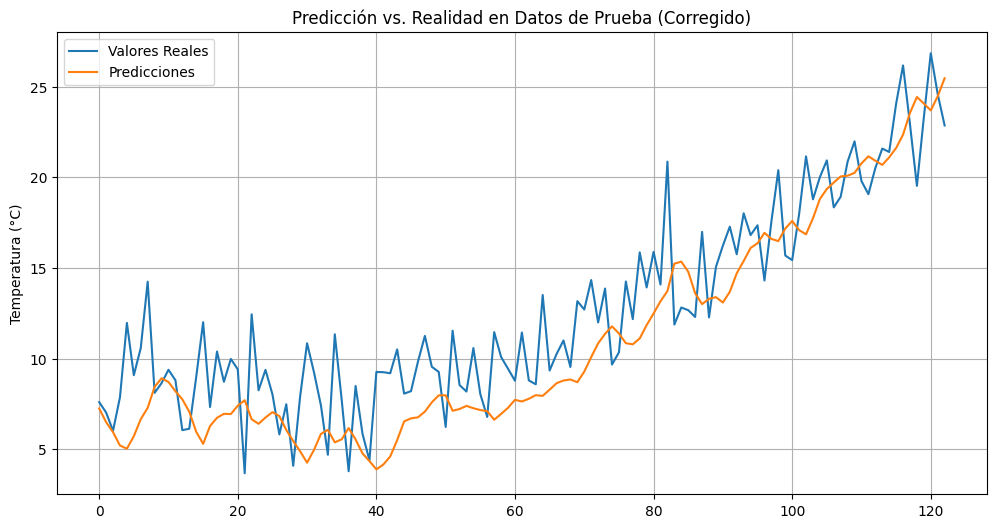

In [15]:
# --- 7. Evaluación y Visualización (CON PASO INVERSO) ---
model.eval()
with torch.no_grad():
    test_preds_normalized = model(X_test)

# --- INVERSE TRANSFORM (Paso crucial para la visualización) ---
# Tenemos que "des-normalizar" los datos para poder compararlos en la escala original (°C)
test_preds = scaler.inverse_transform(test_preds_normalized[:, -1].numpy())
y_test_original = scaler.inverse_transform(y_test[:, -1].numpy())

# Graficar los resultados en la escala original
plt.figure(figsize=(12, 6))
plt.title("Predicción vs. Realidad en Datos de Prueba (Corregido)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.plot(y_test_original, label='Valores Reales')
plt.plot(test_preds, label='Predicciones')
plt.legend()
plt.show()

Epoch [10/100], Loss: 0.0907
Epoch [20/100], Loss: 0.0669
Epoch [30/100], Loss: 0.0439
Epoch [40/100], Loss: 0.0383
Epoch [50/100], Loss: 0.0294
Epoch [60/100], Loss: 0.0213
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0122
Epoch [90/100], Loss: 0.0109
Epoch [100/100], Loss: 0.0096


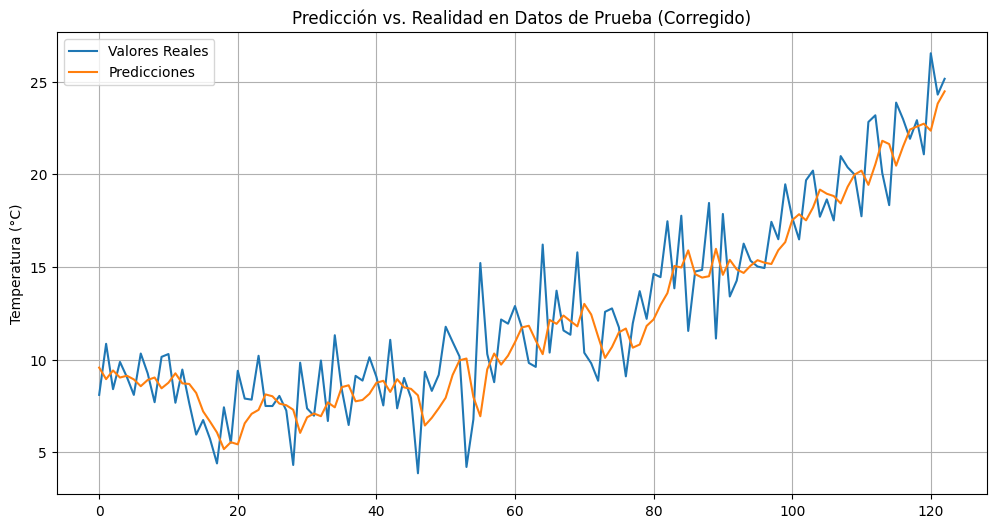

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # <-- IMPORTANTE

# --- 1. Generar Datos Simulados (Igual que antes) ---
time = np.arange(730)
seasonality = 15 * np.sin(2 * np.pi * time / 365)
trend = 0.02 * time
noise = np.random.randn(730) * 2
temperatures = 10 + seasonality + trend + noise

# --- 2. NORMALIZACIÓN DE DATOS (EL PASO CLAVE) ---
# Reshape para el scaler: de (730,) a (730, 1)
data_for_scaling = temperatures.reshape(-1, 1)

# Crear y ajustar el scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_for_scaling)

# Convertir a tensor de PyTorch
data = torch.FloatTensor(data_normalized)

# --- 3. Ventana Deslizante (Igual que antes, pero con datos normalizados) ---
sequence_length = 7
X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i : i + sequence_length])
    y.append(data[i + 1 : i + sequence_length + 1])
X = torch.stack(X)
y = torch.stack(y)

# --- 4. División de Datos (Igual que antes) ---
train_size = 600
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- 5. Arquitectura (Sin cambios) ---
class TempRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# --- 6. Entrenamiento (Sin cambios, pero ahora con datos normalizados) ---
model = TempRNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100 # Puedes probar a aumentarlo a 200 para mejores resultados
for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# --- 7. Evaluación y Visualización (CON PASO INVERSO) ---
model.eval()
with torch.no_grad():
    test_preds_normalized = model(X_test)

# --- INVERSE TRANSFORM (Paso crucial para la visualización) ---
# Tenemos que "des-normalizar" los datos para poder compararlos en la escala original (°C)
test_preds = scaler.inverse_transform(test_preds_normalized[:, -1].numpy())
y_test_original = scaler.inverse_transform(y_test[:, -1].numpy())

# Graficar los resultados en la escala original
plt.figure(figsize=(12, 6))
plt.title("Predicción vs. Realidad en Datos de Prueba (Corregido)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.plot(y_test_original, label='Valores Reales')
plt.plot(test_preds, label='Predicciones')
plt.legend()
plt.show()

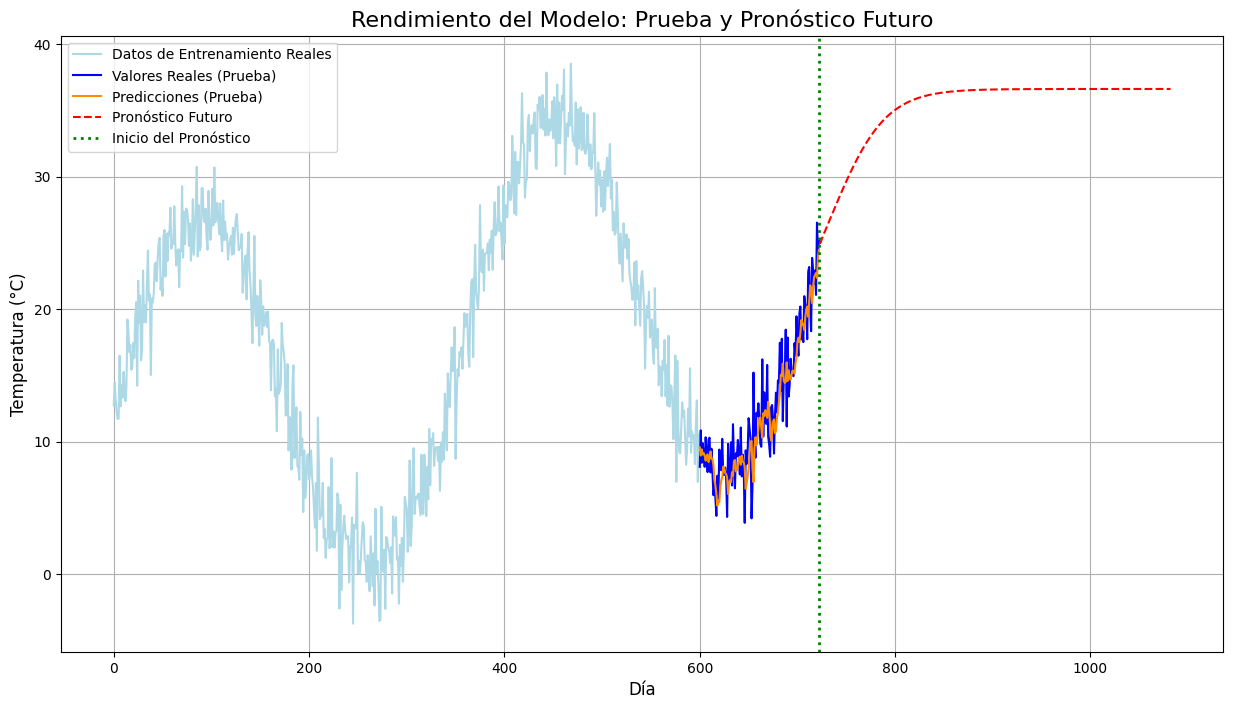

In [23]:
# --- 7 y 8. Evaluación en Datos de Prueba y Pronóstico Futuro Combinados ---

# Ponemos el modelo en modo evaluación
model.eval()

# Lista para guardar las predicciones en los datos de prueba
test_preds_normalized_list = []

# Obtenemos las predicciones para el conjunto de prueba
with torch.no_grad():
    for i in range(len(X_test)):
        # Añadimos la dimensión del batch
        input_tensor = X_test[i].unsqueeze(0)
        # Solo nos interesa la última predicción de la secuencia
        y_pred = model(input_tensor)
        test_preds_normalized_list.append(y_pred[0, -1, :])

# Convertimos la lista de predicciones de prueba a un array de numpy
test_preds_normalized = torch.stack(test_preds_normalized_list).numpy()

# --- Ahora, pronosticamos el futuro ---
days_to_forecast = 360
# Empezamos con la última secuencia del conjunto de datos completo
last_sequence = data[-sequence_length:]
future_predictions_normalized = []

with torch.no_grad():
    for _ in range(days_to_forecast):
        input_tensor = last_sequence.view(1, sequence_length, 1)
        prediction = model(input_tensor)
        next_pred_normalized = prediction[0, -1, :]
        future_predictions_normalized.append(next_pred_normalized)
        last_sequence = torch.cat((last_sequence[1:], next_pred_normalized.view(1, 1)), dim=0)

# Apilamos las predicciones futuras y las convertimos a numpy
future_preds_stacked = torch.stack(future_predictions_normalized).numpy()

# --- INVERSE TRANSFORM (Paso crucial para la visualización) ---
# Des-normalizamos todo para verlo en la escala original (°C)
test_preds = scaler.inverse_transform(test_preds_normalized)
future_preds = scaler.inverse_transform(future_preds_stacked.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test[:, -1].numpy())


# --- GRAFICAR TODO JUNTO ---
plt.figure(figsize=(15, 8))
plt.title("Rendimiento del Modelo: Prueba y Pronóstico Futuro", fontsize=16)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.xlabel("Día", fontsize=12)
plt.grid(True)

# 1. Graficar los datos de entrenamiento (para dar contexto)
train_time_axis = np.arange(train_size)
plt.plot(train_time_axis, scaler.inverse_transform(y_train[:, -1].numpy()), label='Datos de Entrenamiento Reales', color='lightblue')

# 2. Graficar los datos de prueba y las predicciones sobre ellos
test_time_axis = np.arange(train_size, train_size + len(y_test_original))
plt.plot(test_time_axis, y_test_original, color='blue', label='Valores Reales (Prueba)')
plt.plot(test_time_axis, test_preds, color='darkorange', linestyle='-', label='Predicciones (Prueba)')

# 3. Graficar el pronóstico futuro
forecast_axis = np.arange(train_size + len(y_test_original), train_size + len(y_test_original) + days_to_forecast)
plt.plot(forecast_axis, future_preds, color='red', linestyle='--', label='Pronóstico Futuro')

# Añadir una línea vertical para separar la zona de prueba y la de pronóstico
plt.axvline(x=train_size + len(y_test_original) - 1, color='green', linestyle=':', linewidth=2, label='Inicio del Pronóstico')

plt.legend(fontsize=10)
plt.show()

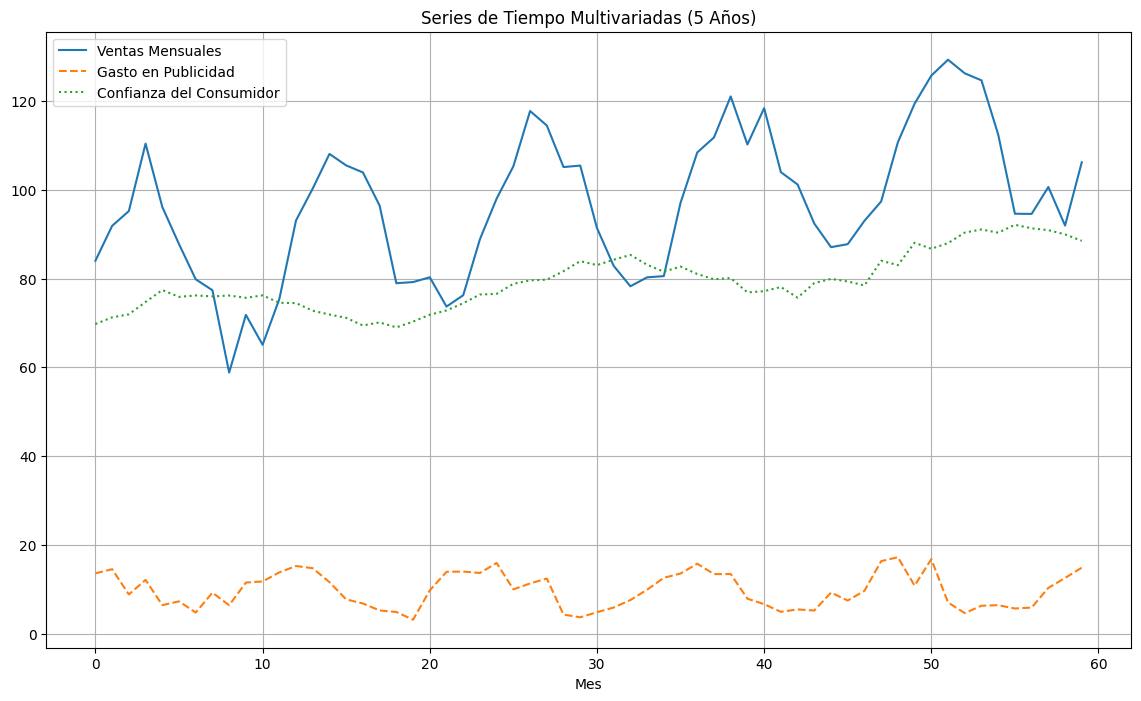

In [26]:
##import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- Generar Datos Simulados (2 Años = 730 días) ---
time = np.arange(730)

# 1. TEMPERATURA: Un ciclo estacional simple.
temperatures = 15 + 10 * np.sin(2 * np.pi * time / 365) + np.random.randn(730) * 2

# 2. DÍA DE LA SEMANA: Un ciclo de 7 días (0=Lunes, 6=Domingo).
day_of_week = time % 7

# 3. VENTAS DIARIAS: Nuestra variable objetivo.
# Tiene una base, una fuerte estacionalidad semanal (más ventas los fines de semana),
# de las ventas del mes pasado. Están influenciadas por otros factores. Usaremos tres series de tiempo que interactúan entre sí:

#1.  **Gasto en Publicidad (Advertising Spend):** Es una variable que tú controlas. Intuitivamente, un mayor gasto en publicidad debería llevar a mayores ventas, quizás con un pequeño retraso.
#2.  **Índice de Confianza del Consumidor (Consumer Confidence):** Una medida económica externa. Si la gente se siente optimista sobre la economía, es más probable que gaste dinero.
#3.  **Ventas Mensuales (Sales):** Esta es nuestra **variable objetivo**, la que queremos predecir. Está influenciada por las otras dos y por su propia historia (estacionalidad, como las ventas navideñas).

#**El objetivo:** Usar la historia de los **últimos 6 meses** de las tres variables (Publicidad, Confianza y Ventas) para predecir las **ventas del próximo mes**.


### Paso 1: Generar Datos Realistas y Librerías

#Simularemos 5 años de datos mensuales (60 puntos de datos).

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- Generar Datos Multivariados Simulados ---
# 60 meses (5 años)
time = np.arange(60)

# 1. Gasto en Publicidad: Estacional, con picos antes de las ventas altas
adv_spend = 10 + 5 * np.sin(2 * np.pi * (time + 3) / 12) + np.random.randn(60) * 2

# 2. Confianza del Consumidor: Se mueve más lentamente, con una tendencia
confidence = 70 + 0.3 * time + 5 * np.sin(2 * np.pi * time / 24) + np.random.randn(60)

# 3. Ventas Mensuales: Estacional (pico en diciembre), tendencia y afectada por las otras dos
sales = 50 + 0.5 * time + 20 * np.sin(2 * np.pi * time / 12) + 0.8 * adv_spend + 0.3 * confidence + np.random.randn(60) * 4

# --- Visualizar las tres series de tiempo ---
plt.figure(figsize=(14, 8))
plt.title("Series de Tiempo Multivariadas (5 Años)")
plt.plot(time, sales, label='Ventas Mensuales')
plt.plot(time, adv_spend, label='Gasto en Publicidad', linestyle='--')
plt.plot(time, confidence, label='Confianza del Consumidor', linestyle=':')
plt.xlabel("Mes")
plt.legend()
plt.grid(True)
plt.show()

# --- Combinar en un solo array ---
# El orden es importante: [Ventas, Publicidad, Confianza]
# Añadimos .T.reshape(-1, 3) para apilarlas correctamente
multivariate_data = np.stack([sales, adv_spend, confidence], axis=1)

In [27]:
# Normalizar las 3 características al rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(multivariate_data)

# Convertir a tensor de PyTorch
data = torch.FloatTensor(data_normalized)

In [28]:
sequence_length = 6 # Usaremos 6 meses de historia
X = []
y = []

for i in range(len(data) - sequence_length):
    # La secuencia de entrada contiene las 3 variables para 6 meses
    # Forma: [6, 3]
    X.append(data[i : i + sequence_length])

    # La salida es SOLO la venta del mes siguiente (la primera columna)
    y.append(data[i + sequence_length, 0]) # Columna 0 = Ventas

X = torch.stack(X)
y = torch.FloatTensor(y).view(-1, 1)

print("Forma de X:", X.shape) # --> Debería ser [54, 6, 3]
print("Forma de y:", y.shape) # --> Debería ser [54, 1]

Forma de X: torch.Size([54, 6, 3])
Forma de y: torch.Size([54, 1])


In [29]:
train_size = 42 # Aproximadamente 42 meses para entrenar
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [30]:
class MultivariateRNN(nn.Module):
    # La arquitectura es la misma, solo cambiaremos el valor de input_size al crearla
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)

        # Usamos la arquitectura "Muchos-a-Uno"
        # Solo tomamos el último estado oculto para la predicción final
        out = self.fc(out[:, -1, :])

        return out

In [31]:
# --- ADAPTACIÓN CLAVE: Instanciamos el modelo con input_size=3 ---
model = MultivariateRNN(input_size=3, hidden_size=50, output_size=1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Bucle de entrenamiento
epochs = 200 # Aumentamos las épocas para un problema más complejo
for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [20/200], Loss: 0.0101
Epoch [40/200], Loss: 0.0051
Epoch [60/200], Loss: 0.0042
Epoch [80/200], Loss: 0.0038
Epoch [100/200], Loss: 0.0035
Epoch [120/200], Loss: 0.0034
Epoch [140/200], Loss: 0.0033
Epoch [160/200], Loss: 0.0031
Epoch [180/200], Loss: 0.0030
Epoch [200/200], Loss: 0.0029


/tmp/ipython-input-32-1902376280.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummy_array[:, 0] = test_preds_normalized.flatten()
/tmp/ipython-input-32-1902376280.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummy_array[:, 0] = y_test.flatten()


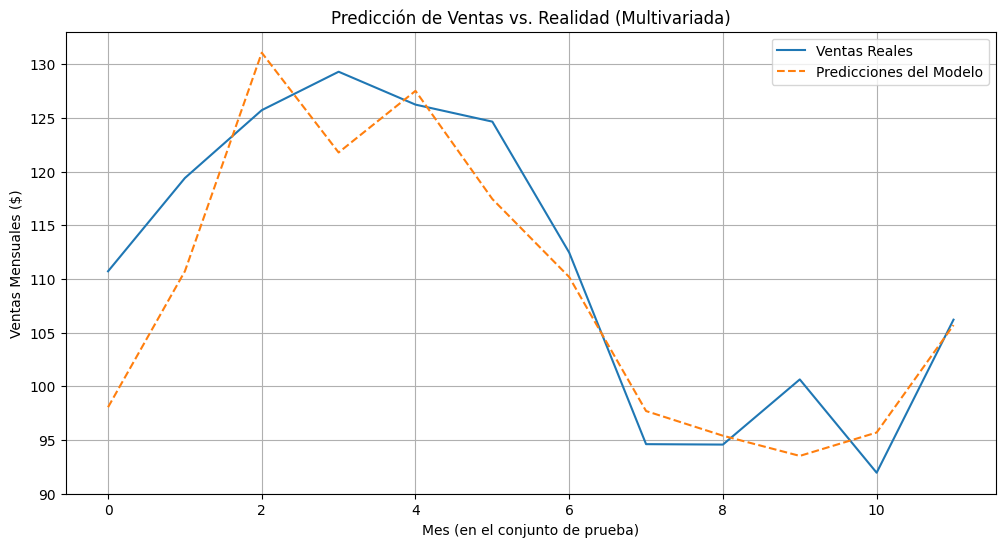

In [32]:
# --- Evaluación en el conjunto de prueba ---
model.eval()
with torch.no_grad():
    test_preds_normalized = model(X_test)

# --- INVERSE TRANSFORM (Paso crucial para la visualización multivariada) ---
# El scaler espera un array con 3 columnas. Creamos un array vacío
# y ponemos nuestras predicciones en la primera columna (la de "Ventas").
dummy_array = np.zeros((len(test_preds_normalized), 3))
dummy_array[:, 0] = test_preds_normalized.flatten()
test_preds = scaler.inverse_transform(dummy_array)[:, 0] # Tomamos solo la primera columna des-normalizada

# Hacemos lo mismo para los datos de prueba reales
dummy_array[:, 0] = y_test.flatten()
y_test_original = scaler.inverse_transform(dummy_array)[:, 0]

# --- Graficar los resultados ---
plt.figure(figsize=(12, 6))
plt.title("Predicción de Ventas vs. Realidad (Multivariada)")
plt.ylabel("Ventas Mensuales ($)")
plt.xlabel("Mes (en el conjunto de prueba)")
plt.grid(True)
plt.plot(y_test_original, label='Ventas Reales')
plt.plot(test_preds, label='Predicciones del Modelo', linestyle='--')
plt.legend()
plt.show()